# Preamble on documentation
As a newcomer to this repository with a fresh impression of it I tried to find the most unclear parts and suggest a solution how to improve them. In my opinion the weak point of the repository is its code structure: no clear modules or libraries were created, ipython notebooks are used as modules, which isn't the best architectural solution. These specifics force to write documentation on separate notebooks instead of classes or functions, which leads to incomplete documentation and additional complexity of orientation in the project. Along with that a lot of code is duplicated in different notebooks, which can also be solved with the code refactoring and structure change.

When we have a clear architecture we are able to easily reveal the functionality of our project, reduce the length of demonstration notebooks and make them more comprehensive.


# GSoC exercise approach
As this repository is the starting point for the GSoC project, I decided to focus on existing code, it's usage and refactoring instead of implementing the duplicating functionality with my own. In addition to general task, training an autoencoder for 4D$\to$3D compression, I had the following goals when doing the evaluation exercise:
1. Reduce the number of .ipynb-notebooks in the project, using .py-files is more portable and flexible.
2. Start building a library inside: compression module, root2pickle reader, evaluation plotting module. All the tasks that could be separated, should be separated, reuse the code where it's possible.
3. Make writing documentation easier and more clear - good architecture is a key. 
4. Reduce the amount of code needed to demonstrate the full process of autoencoder training and evaluation without loss of flexibility. 


# Architecture: what was achieved
#### Note: the majority of changes were applied to 4D autoencoders and the process of training such models. 

1. **Compression module.** The main goal of this project is to provide good compression quality for some data. This suggests to have a compression module which contains all necessary code for compression algorithms: autoencoders, future autoencoders with classical compression algorithms and similar staff, `compression/` - new place for this.

2. **Autoencoders: 4D.** After we have a special module for compression algorithms all autoencoders should be moved to `compression/autoencoder.py`. Previously ~30 separated autoencoder classes were fully implemented in `utils_nn.py`. Why not to create a configurable class for autoencoders? All autoencoders for 4D-model were rewritten with one configurable `class Autoencoder` in `compression/autoencoder.py`. The layers sizes and activation functions can be passed as parameters, old interfaces were kept. After these updates code volume for 4D autoencoders was reduced by 50%, it takes just 5 lines to add a new version of autoencoder with custom parameters.

3. **Evaluation plots.** To evaluate each new model a set of standard plots is used: data histograms, residuals plots, activation plots. These functions had two implementations: one in the notebook, another one in the `utils.py` file. There is no need to have several versions and fully copy this functions to notebooks, therefore a separate file `utils/evaluation_plots.py` was created and provides now the only implementation, which is used.

4. **Reuse of code.** I tried to reuse as much code as it's possible and `utils.py` was really helpful for this. Normalization, reconstruction, initial plotting functions were already implemented there.


# Architecture: how to proceed
1. **ROOT2Pickle.** Debug `utils/root2pickle_reader.py` with real `.root`-data and remove 2 unnecessary notebooks(`process_ROOT_27D.ipynb`, `process_ROOT_4D.ipynb`).

2. **Autoencoders: 27D.** Refactor the rest autoencoders in `nn_utils.py` created for 27-dimensional input. The same approach should be used and one more autoencoder constructor should be created in `autoencoder.py`. After that the `nn_utils.py` file should be removed.

3. **Future refactoring.** Use `.py`-files where it's possible, if it's not a demonstation or pure research work. Check repository for dead imports(e.g. `my_nn_modules` in `27D_train.py` is not copied from the original repository, but is imported). Filter code to `utils/` where it's necessary(I didn't do it to keep other files working).

3. **Documentation.** Write documentation on newly separated modules, but it's good to remember that clear code is an additional useful documentation by itself.

# Autoencoder: 
1. Compression techniques should be applied in addition to existing models
2. Try additional methods for regularization, try other activations. Try dropout with relu and add relu to the final layer(no such activation now), maybe dropout will be useful then.
2. Autoencoders for anomaly detection.

# GSoC main exercise

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Import necessary modules, upload the data

In [2]:
import pandas as pd
import numpy as np
import fastai
from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats, EarlyStoppingCallback
import torch
from torch.utils.data import TensorDataset

from compression.autoencoder import AE_3D_200, RMSELoss
from nn_utils import get_data
from utils import normalize, unnormalized_reconstructions
from utils.evaluation_plots import plot_histograms, plot_residuals
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

train_file = '../data/all_jets_train_4D_100_percent.pkl'
test_file = '../data/all_jets_test_4D_100_percent.pkl'
batch_size = 128

train = pd.read_pickle(train_file)
test = pd.read_pickle(test_file)

train.head(5)

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871


## Split train data into train and validation sets. Test set will be used only to report the result.

In [3]:
train_x, valid_x, _, _ = train_test_split(train, train, test_size=0.2)
train_norm, valid_norm = normalize(train_x, valid_x)

# input and output are the same for the autoencoder
train_ds = TensorDataset(torch.FloatTensor(train_norm.to_numpy()), torch.FloatTensor(train_norm.to_numpy()))
valid_ds = TensorDataset(torch.FloatTensor(valid_norm.to_numpy()), torch.FloatTensor(valid_norm.to_numpy()))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs=batch_size)
db = basic_data.DataBunch(train_dl, valid_dl)

## Plot train and validation data

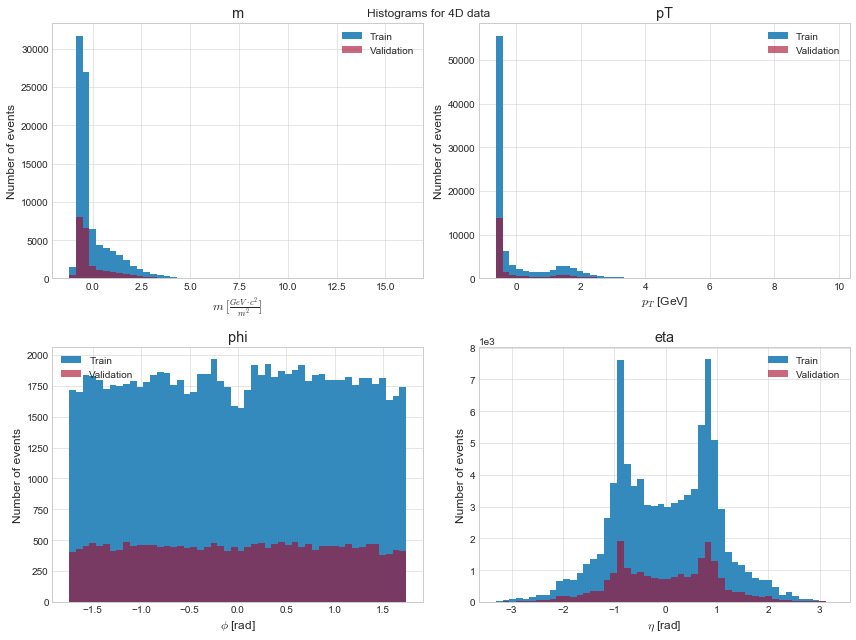

In [4]:
plot_histograms(valid_norm.to_numpy(), train_norm.to_numpy(), bins=50, labels=['Train', 'Validation'])

In [5]:
model = AE_3D_200()
loss_func = RMSELoss()

wd = 1e-6
learn = basic_train.Learner(
    data=db,
    model=model,
    loss_func=loss_func,
    wd=wd,
    bn_wd=False,
    true_wd=True,
    callback_fns=[ActivationStats]
)

## Find learning rates range, we use both the suggestions from the fastai and the minimal value

In [6]:
from fastai import train as tr
tr.lr_find(learn)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.51E-03
Min loss divided by 10: 3.98E-03


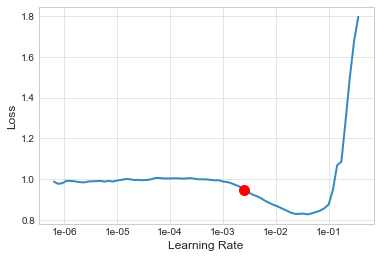

In [7]:
learn.recorder.plot(suggestion=True)

In [8]:
min_grad_lr = learn.recorder.min_grad_lr

losses = learn.recorder.losses
lrs = learn.recorder.lrs

min_lr = lrs[losses.index(min(losses))]

# the values within the suggested learning rate from fastai and the minimum of loss are used
learning_rates = np.arange(min_grad_lr, min_lr, 0.01)
print("Learning rates range: ", learning_rates)

Learning rates range:  [0.002512 0.012512 0.022512 0.032512]


In [9]:
# enable gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## To evaluate each model training and validation losses are depicted on graphs and directly printed during the learning process.
Early stopping is used here: if the validation loss doesn't increase during 5 iterations - stop learning.

Evaluation for lr = 0.002511886431509582


epoch,train_loss,valid_loss,time
0,0.182587,0.181801,00:12
1,0.175796,0.172130,00:12
2,0.169254,0.168094,00:11
3,0.149584,0.162280,00:11
4,0.151371,0.148831,00:12
5,0.146377,0.150354,00:11
6,0.143297,0.146675,00:11
7,0.142249,0.153871,00:11
8,0.144866,0.160611,00:12
9,0.136308,0.139363,00:16


Epoch 16: early stopping


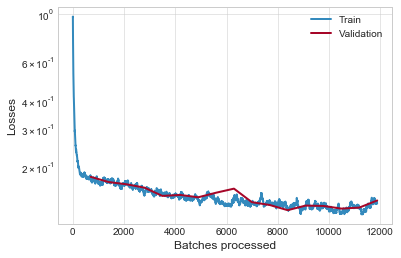

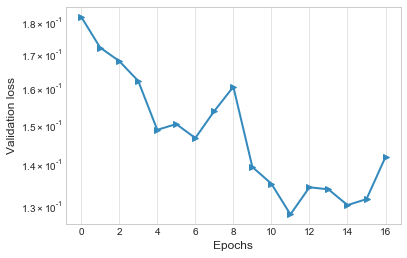

Evaluation for lr = 0.012511886431509581


epoch,train_loss,valid_loss,time
0,0.216528,0.207295,00:15
1,0.213914,0.198721,00:12
2,0.204592,0.224438,00:12
3,0.197046,0.191032,00:12
4,0.199734,0.199675,00:12
5,0.198460,0.206568,00:14
6,0.210722,0.210206,00:12
7,0.198533,0.189988,00:13
8,0.201188,0.200203,00:14


Epoch 9: early stopping


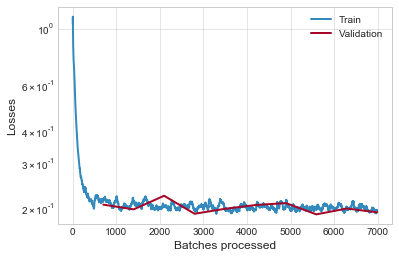

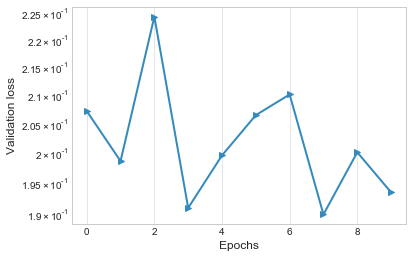

Evaluation for lr = 0.02251188643150958


epoch,train_loss,valid_loss,time
0,0.269678,0.260973,00:13
1,0.252182,0.239678,00:13
2,0.239628,0.236902,00:13
3,0.261008,0.281181,00:13
4,0.250640,0.262146,00:14
5,0.245542,0.237060,00:13
6,0.249885,0.257300,00:13


Epoch 7: early stopping


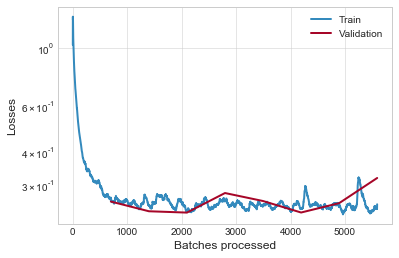

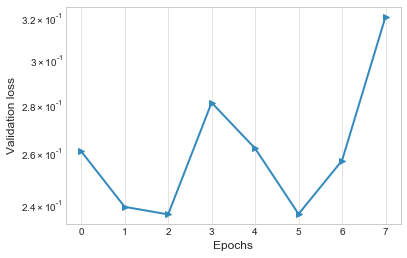

Evaluation for lr = 0.032511886431509575


epoch,train_loss,valid_loss,time
0,0.483214,0.480113,00:13
1,0.528495,0.495691,00:13
2,0.587987,0.595899,00:13
3,0.642618,0.593301,00:13
4,0.764097,0.802230,00:13
5,0.598018,0.588790,00:13


Epoch 6: early stopping


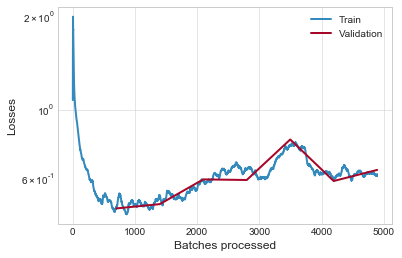

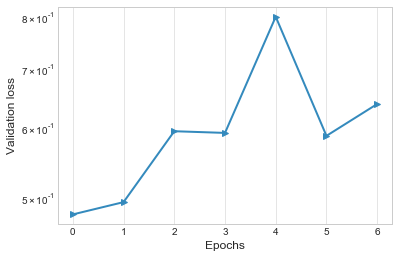

In [10]:
learns = []
for lr in learning_rates:
    print("Evaluation for lr =", lr)
    model = AE_3D_200()
    model.to(device)
    loss_func = RMSELoss()
    learn = basic_train.Learner(
        data=db,
        model=model,
        loss_func=loss_func,
        wd=1e-6,
        bn_wd=False,
        true_wd=True,
        callback_fns=[ActivationStats],
    )
    learn.fit(
        30,
        lr=lr,
        callbacks=EarlyStoppingCallback(
            learn=learn, monitor="valid_loss", min_delta=0.01, patience=5
        ),
    )
    learns.append(learn)
    learn.recorder.plot_losses()
    plt.ylabel('Losses')
    plt.yscale('log')
    plt.show()    
    plt.plot(learn.recorder.val_losses, marker='>')
    plt.yscale('log')
    plt.ylabel('Validation loss')
    plt.xlabel('Epochs')
    plt.show()

## Choose the best model.
We see that the first model is the best one with the lowest validation loss.

In [11]:
validation_result = [learns[i].validate() for i in range(len(learns))]
print(validation_result)
best_model_id = validation_result.index(min(validation_result))
print("Best model id: ", best_model_id)
model = learns[best_model_id].model

[[0.14187402], [0.19355442], [0.32076347], [0.6395539]]
Best model id:  0


# Testing the best model, report results on test data

Let's use the test data to see how good is our autoencoder. Histograms for input and decompressed data are shown along with the residuals plots.

In [20]:
model.to('cpu')
idxs = (0, test.shape[0])
pred, data = unnormalized_reconstructions(model, test, force_mean = train_x.mean(), force_std = train_x.std(), idxs=idxs)

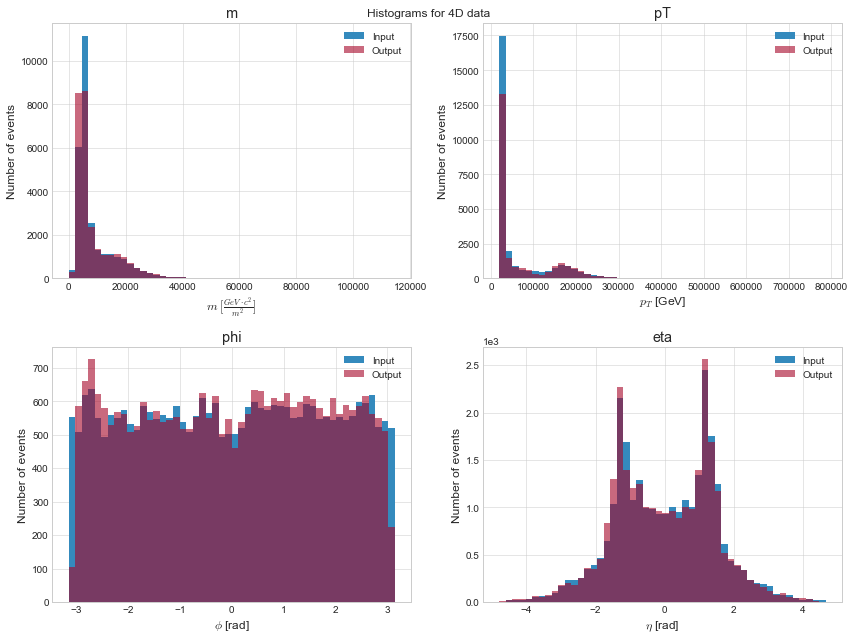

In [22]:
plot_histograms(pred, data.numpy(), bins=50)

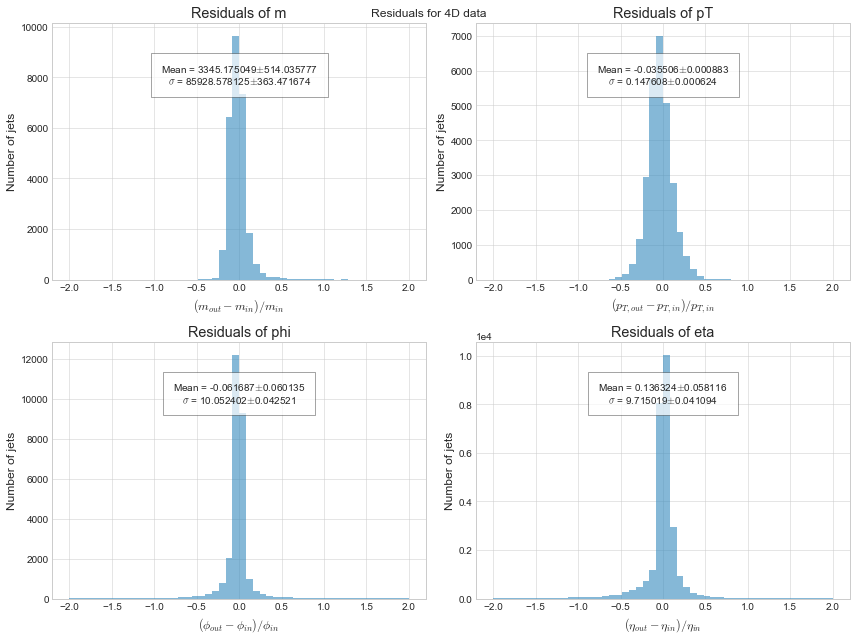

In [32]:
plot_residuals(pred.detach().numpy(), data.detach().numpy(), bins=50)

## Results analysis

We see that the initial data distribution and the decompressed data on the joint histogram look similar to each other.
What concerns the residuals, the majority of residuals are rather small. Inaccuracy and higher errors for the mass may be caused by the training approach(e.g. learning rate decrease can be applied like in the original paper), data split(no cross validation was applied) and the absence of custom normalization described in the original paper.